In [1]:
import os
import math
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pyquaternion import Quaternion
import cv2
import copy
from matplotlib.axes import Axes

C:\Users\prudh\.conda\envs\hello\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\prudh\.conda\envs\hello\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\prudh\.conda\envs\hello\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
class Sensorfusion:

    def __init__(self,filepath,jsonpath):
        self.table_dict = {}
        self.table_dict_token = {}
        self.table_names = ["category","attribute","visibility",
            "instance","sensor","calibrated_sensor","ego_pose",
            "log","scene","sample","sample_data","sample_annotation","map",
        ]
        self.filepath = filepath
        self.json_path = jsonpath
        for tablename in self.table_names:
            self.table_dict[tablename]= self.Load_table(tablename)
            self.table_dict_token[tablename] = self.Load_table_token(tablename)

        from imageai.Detection import ObjectDetection 
        self.recognizer = ObjectDetection() 
        self.recognizer.setModelTypeAsTinyYOLOv3()  
        self.recognizer.setModelPath("C:\\Users\\prudh\\Documents\\32sem\\industry_research_project\\multicore_sensor_fusion\\Nuscene_all\\dataset\\yolo-tiny.h5")  
        self.recognizer.loadModel()

        %matplotlib inline
        from nuscenes.nuscenes import NuScenes
        self.nusc = NuScenes(version=self.json_path.split("\\")[-1], dataroot=self.filepath, verbose=True)

    def Load_table(self, table_name: str):
        filepath = os.path.join(self.json_path , f"{table_name}.json")
        try:
            with open(str(filepath)) as f:
                table = json.load(f)
            return table           
        except:
            print(f"JSON file {table_name}.json missing, using empty list")
            return []

    def Load_table_token(self, table_name: str):
        filepath = os.path.join(self.json_path , f"{table_name}.json")
        try:
            with open(str(filepath)) as f:                
                table = json.load(f)
                changed = {}
                for record in table:
                    changed[record["token"]]=record
            return changed           
        except:
            print(f"JSON file {table_name}.json missing, using empty list")
            return {}

    def boxes_label(self,cam_front_data):
        return  self.nusc.get_boxes(cam_front_data['token'])

    def yolo_detection(self,filename):
        
        print("output: ",self.filepath+"/"+'output'+"/"+filename.split("/")[-1])
        recognition = self.recognizer.detectObjectsFromImage(  
            input_image = self.filepath+"/"+filename,  
            output_image_path = self.filepath+"/"+'output'+"/"+filename.split("/")[-1]
        ) 
        
        plt.figure(figsize=(9, 16))
        image = Image.open(str(self.filepath+"/"+'output'+"/"+filename.split("/")[-1]))
        plt.imshow(image)
        plt.axis("off")


    def draw_lidar_on_image(self,sample_tk,sample_token_num,cam_sensor_channel,lidar_sensor_channel):

        self.all_info = {}
        # self.sample_tk =sample_tk
        self.cam_sensor_channel = cam_sensor_channel
        self.lidar_sensor_channel = lidar_sensor_channel
        scene_tk = self.table_dict_token["scene"][tuple(self.table_dict_token["scene"].keys())[sample_tk]]['first_sample_token']
        self.sample_tk = self.table_dict_token["sample"][scene_tk]["token"]
        
        sample_token = self.table_dict_token["sample"][self.sample_tk]['next']
        sample_token = self.table_dict_token["sample"][sample_token]['next']
        for i in range(sample_token_num):    
            sample_token = self.table_dict_token["sample"][sample_token]['next']
            if(sample_token==''):
                print(i)
                break
        print(sample_token)
        self.sample_tk = sample_token
# =====================================================
        sample_data = self.table_dict_token["sample_data"]
        for tk in self.table_dict_token["sample_data"].keys():
            if(sample_data[tk]["sample_token"]==self.sample_tk):  
                # print(sample_data[tk]["sample_token"] ,self.sample_tk)              
                if "all_sensors" not in self.all_info.keys():
                    self.all_info['all_sensors'] = [sample_data[tk]]
                else:
                    self.all_info['all_sensors'].append(sample_data[tk])
        
        for sensor_data_10 in self.all_info['all_sensors']:
            sensor_tk = self.table_dict_token["calibrated_sensor"][sensor_data_10['calibrated_sensor_token']]['sensor_token']
            sensor_data_10['sensor_modility'] = self.table_dict_token['sensor'][sensor_tk]['modality']
            sensor_data_10['sensor_channel'] = self.table_dict_token['sensor'][sensor_tk]['channel']

        lidar_sc_data = [i for i in self.all_info['all_sensors'] if i['sensor_channel']==self.lidar_sensor_channel][0]
        cam_sc_data = [i for i in self.all_info['all_sensors'] if i['sensor_channel']==self.cam_sensor_channel][0]
# ==============================================================
        print(lidar_sc_data['filename'])
        scan = np.fromfile(str(self.filepath+"/"+lidar_sc_data['filename']), dtype=np.float32)
        if(lidar_sensor_channel[:5]=='LIDAR'):            
            print(scan.shape)
            points = scan.reshape((-1, 5))[:, : 4]
            print(points.shape)
            points = points.T
            print(points.shape)
            print(points,points.shape)
        else:
            print(scan.shape)
            print(scan)
            points = scan.reshape((-1, 3))
            print(points.shape)
            points = points.T
            print(points.shape)
            print(points,points.shape)
            points_r = np.concatenate( (points, np.ones((1, points.shape[1])) ) )
            print(points_r,points_r.shape)
#==========================================================================
        #Converting 3D point cloud Data to World Coordinate System(multiple with ego pose/ translation and rotation)
        # Points live in the point sensor frame. So they need to be transelformed via global to the image plane.
        # First step: transform the point-cloud to the ego vehicle frame for the timestamp of the sweep.
        print("First step: transform the point-cloud to the ego vehicle frame for the timestamp of the sweep.")
        #All about calibrated lidar sensor attribute pre-processing with points
        calibrated_lidar_tk = self.table_dict_token["calibrated_sensor"][lidar_sc_data["calibrated_sensor_token"]]
        #Appliying dot or multiplication on lidar points with calibrated lidar sensor rotation (matrix 3x3)
        print("rotation matrix before Quaternion : \n",calibrated_lidar_tk["rotation"])
        matrix = Quaternion(calibrated_lidar_tk["rotation"]).rotation_matrix
        print("rotation matrix lidar: \n",matrix,matrix.shape)
        points[:3, :] = np.dot(matrix, points[:3, :])
        print("Points after rotation : \n")
        print(points.shape)
        print(points,points.shape)
        #applying translation on points with calibrated lidar sensor translation values (matrix 1 x 3)
        translation_matrix = np.array(calibrated_lidar_tk["translation"])
        print("translation matrix calibrated lidar:\n", translation_matrix)
        for i in range(3):
            points[i, :] = points[i, :] + translation_matrix[i]
        print("points after translation : \n",points)
#===================================================================================
        # Second step: transform to the global frame.
        #All about ego pose of lidar sensor attribute pre-processing with points
        print("Second step: transform to the global frame.")
        lidar_ego_pose_tk = sf.table_dict_token["ego_pose"][lidar_sc_data["ego_pose_token"]]
        print(lidar_ego_pose_tk)
        #Appliying dot or multiplication on lidar points with ego pose of lidar sensor rotation (matrix 3x3)
        print("rotation matrix before Quaternion : \n",lidar_ego_pose_tk["rotation"])
        ego_matrix = Quaternion(lidar_ego_pose_tk["rotation"]).rotation_matrix
        print("rotation matrix ego lidar : \n",ego_matrix,ego_matrix.shape)
        points[:3, :] = np.dot(ego_matrix, points[:3, :])
        print("Points after rotation : \n")
        print(points.shape)
        print(points,points.shape)
        #applying translation on points with calibrated lidar sensor translation values (matrix 1 x 3)
        translation_matrix_ego = np.array(lidar_ego_pose_tk["translation"])
        print("translation matrix ego lidar :\n", translation_matrix_ego)
        for i in range(3):
            points[i, :] = points[i, :] + translation_matrix_ego[i]
        print("points after translation : \n",points)
#===============================================================================================
        #Convert from World Coordinate System to Camera Coordinate System with camera rotation and translation values

        # Third step: transform into the ego vehicle frame for the timestamp of the image
        print("Third step: transform into the ego vehicle frame for the timestamp of the image")
        cam_ego_pose_tk = self.table_dict_token["ego_pose"][cam_sc_data["ego_pose_token"]]
        #applying translation on points with camera sensor translation values (matrix 1 x 3)
        translation_matrix_cam_ego = -np.array(cam_ego_pose_tk["translation"])
        print("translation matrix of ego camera:\n", translation_matrix_cam_ego)
        for i in range(3):
            points[i, :] = points[i, :] + translation_matrix_cam_ego[i]
        print("points after translation : \n",points)
        #Appliying dot or multiplication on lidar points with ego pose of Camera sensor rotation (matrix 3x3)
        print("rotation matrix before Quaternion : \n",cam_ego_pose_tk["rotation"])
        cam_ego_matrix = Quaternion(cam_ego_pose_tk["rotation"]).rotation_matrix.T
        print("rotation matrix of ego camera: \n",cam_ego_matrix,cam_ego_matrix.shape)
        points[:3, :] = np.dot(cam_ego_matrix, points[:3, :])
        print("Points after rotation : \n")
        print(points.shape)
        print(points,points.shape)
#===============================================================================================
        # Fourth step: transform into the camera.
        print(' Fourth step: transform into the camera.')
        calibrated_cam_tk = sf.table_dict_token["calibrated_sensor"][cam_sc_data["calibrated_sensor_token"]]
        #applying translation on points with camera sensor translation values (matrix 1 x 3)
        translation_matrix_cam_calibrated = -np.array(calibrated_cam_tk["translation"])
        print("translation matrix of calibrated camera:\n", translation_matrix_cam_calibrated)
        for i in range(3):
            points[i, :] = points[i, :] + translation_matrix_cam_calibrated[i]
        print("points after translation : \n",points)
        #Appliying dot or multiplication on lidar points with ego pose of Camera sensor rotation (matrix 3x3)
        print("rotation matrix before Quaternion : \n",calibrated_cam_tk["rotation"])
        cam_calibrated_matrix = Quaternion(calibrated_cam_tk["rotation"]).rotation_matrix.T
        print("rotation matrix of calibrated camera: \n",cam_calibrated_matrix,cam_calibrated_matrix.shape)
        points[:3, :] = np.dot(cam_calibrated_matrix, points[:3, :])
        print("Points after rotation : \n")
        print(points.shape)
        print(points,points.shape)

#===============================================================================================
        #Convert from 3D camera coordinate system to 2D camera Frame

        #Fifth step: actually take a "picture" of the point cloud.
        # Grab the depths (camera frame z axis points away from the camera)
        print("Fifth step: actually take a picture of the point cloud.")
        depths =points[2, :]
        # Retrieve the color from the depth.
        coloring = depths
        # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
        # points = view_points(points[:3, :], np.array(calibrated_cam_tk["camera_intrinsic"]), normalize=True)

        points_r = points[:3,:]
        viewpad = np.eye(4)
        view = np.array(calibrated_cam_tk["camera_intrinsic"])
        print(view.shape,view)
        viewpad[: view.shape[0], : view.shape[1]] = view
        nbr_points = points.shape[1]
        print(nbr_points)
        print(viewpad,viewpad.shape)
        # Do operation in homogenous coordinates
        points_r = np.concatenate( (points_r, np.ones((1, nbr_points)) ) )
        points_r = np.dot(viewpad, points_r) # 4 x 4  , 4 x 107845 =  4 x 107845
        print(points_r,points_r.shape)
        points_r = points_r[:3,:]
        print(points_r,points_r.shape)
#===============================================================================================
        normalize = True
        if normalize:
            points_r = points_r / points_r[2:3, :].repeat(3, 0).reshape(3, nbr_points)
            
        mask = np.ones(depths.shape[0], dtype=bool) # 107845
        print(mask,mask.shape)

        mask = np.logical_and(mask, depths > 0) # points[2,:]
        print(mask,mask.shape)
        print(sum([1 for i in mask if i == True]))

        print("For x_axis : ")
        mask = np.logical_and(mask, points_r[0, :] > 1) #points[0,:]
        print(mask,mask.shape)
        print(sum([1 for i in mask if i == True]))
        
        image = Image.open(str(self.filepath+"/"+cam_sc_data['filename']))
        print(image.size) #(1920, 1080)
        mask = np.logical_and(mask, points_r[0, :] < image.size[0] - 1) # points[0,:]
        print(mask,mask.shape)
        print(sum([1 for i in mask if i == True]))

        print("For Y_axis : ")

        mask = np.logical_and(mask, points_r[1, :] > 1) # points[1,:]
        print(mask,mask.shape)
        print(sum([1 for i in mask if i == True]))

        mask = np.logical_and(mask, points_r[1, :] < image.size[1] - 1) #points[1:,]
        print(mask,mask.shape)
        print(sum([1 for i in mask if i == True]))

        points_r_mask = points_r[:, mask]
        coloring_mask = coloring[mask]
        print(cam_sc_data['filename'])
        self.yolo_detection(cam_sc_data['filename'])
        plt.figure(figsize=(9, 16))
        plt.imshow(image)
        plt.scatter(points_r_mask[0, :], points_r_mask[1, :], c=coloring_mask, s=10)
        plt.axis("off")

        return 

        

In [3]:
path = "train_data\\mini"
sf = Sensorfusion(filepath = "train_data",jsonpath=path)

Loading NuScenes tables for version mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.2 seconds.
Reverse indexing ...
Done reverse indexing in 0.3 seconds.


In [80]:
my_scene = sf.nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
my_sample = sf.nusc.get('sample', first_sample_token)    
sensor = 'CAM_FRONT'
cam_front_data = sf.nusc.get('sample_data', my_sample['data'][sensor])
all_boxes = sf.boxes_label(cam_front_data)

In [82]:
all_boxes[0]

label: nan, score: nan, xyz: [373.26, 1130.42, 0.80], wlh: [0.62, 0.67, 1.64], rot axis: [0.00, 0.00, -1.00], ang(degrees): 21.09, ang(rad): 0.37, vel: nan, nan, nan, name: human.pedestrian.adult, token: ef63a697930c4b20a6b9791f423351da

In [66]:
first_boxes = sf.boxes_label()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

In [67]:
first_boxes

[label: nan, score: nan, xyz: [373.26, 1130.42, 0.80], wlh: [0.62, 0.67, 1.64], rot axis: [0.00, 0.00, -1.00], ang(degrees): 21.09, ang(rad): 0.37, vel: nan, nan, nan, name: human.pedestrian.adult, token: ef63a697930c4b20a6b9791f423351da,
 label: nan, score: nan, xyz: [378.89, 1153.35, 0.86], wlh: [0.78, 0.77, 1.71], rot axis: [0.00, 0.00, 1.00], ang(degrees): -112.89, ang(rad): -1.97, vel: nan, nan, nan, name: human.pedestrian.adult, token: 6b89da9bf1f84fd6a5fbe1c3b236f809,
 label: nan, score: nan, xyz: [353.79, 1132.36, 0.60], wlh: [2.01, 4.63, 1.57], rot axis: [0.00, 0.00, -1.00], ang(degrees): 23.11, ang(rad): 0.40, vel: nan, nan, nan, name: vehicle.car, token: 924ee6ac1fed440a9d9e3720aac635a0,
 label: nan, score: nan, xyz: [376.13, 1158.51, 0.94], wlh: [0.75, 0.82, 1.64], rot axis: [0.00, 0.00, 1.00], ang(degrees): 64.77, ang(rad): 1.13, vel: nan, nan, nan, name: human.pedestrian.adult, token: 91e3608f55174a319246f361690906ba,
 label: nan, score: nan, xyz: [410.07, 1196.77, 0.66],

In [40]:
first_sample_token = sf.nusc.scene[0]['first_sample_token']
my_sample = sf.nusc.get('sample', first_sample_token) 
data = sf.nusc.get('sample_data', my_sample['data']['CAM_FRONT'])

In [52]:
data

{'token': 'e3d495d4ac534d54b321f50006683844',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'ego_pose_token': 'e3d495d4ac534d54b321f50006683844',
 'calibrated_sensor_token': '1d31c729b073425e8e0202c5c6e66ee1',
 'timestamp': 1532402927612460,
 'fileformat': 'jpg',
 'is_key_frame': True,
 'height': 900,
 'width': 1600,
 'filename': 'samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg',
 'prev': '',
 'next': '68e8e98cf7b0487baa139df808641db7',
 'sensor_modality': 'camera',
 'channel': 'CAM_FRONT'}

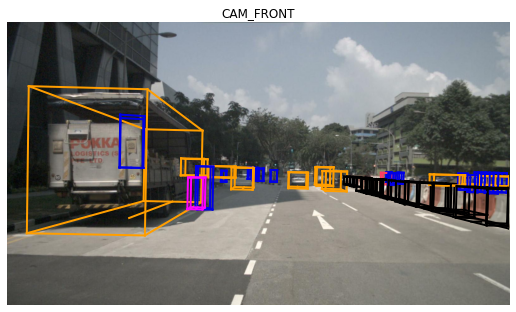

In [45]:
first_boxes = sf.boxes(data['token'])

output:  train_data/output/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg


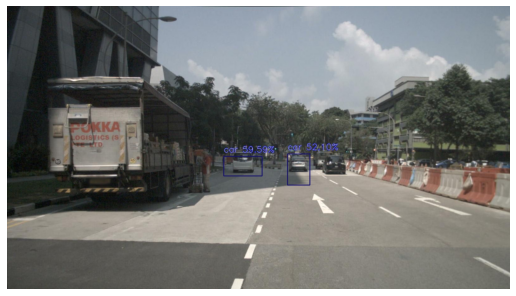

In [85]:
sf.yolo_detection(data['filename'])

output:  train_data/output/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151603662404.jpg


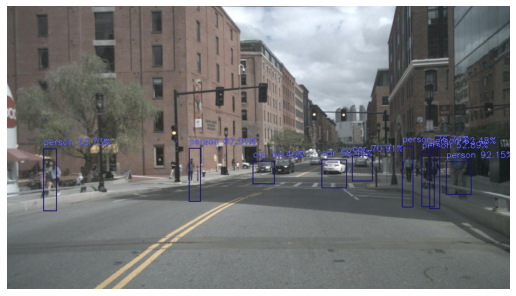

In [83]:
# sf.yolo_detection("sweeps/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402933162460.jpg")
sf.yolo_detection("sweeps/CAM_FRONT/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151603662404.jpg")


In [47]:
first_boxes

b7f64f73e8a548488e6d85d9b0e13242
samples/LIDAR_TOP/n008-2018-08-28-16-43-51-0400__LIDAR_TOP__1535489299547057.pcd.bin
(173440,)
(34688, 4)
(4, 34688)
[[-2.4685953e+00 -2.4864194e+00 -2.5005329e+00 ... -2.1587795e+01
  -2.1574764e+01 -2.1525234e+01]
 [ 2.6359810e-03  3.4828738e-03  3.9837076e-03 ... -1.8867444e-02
  -1.1271696e-02 -3.7786060e-03]
 [-1.4640411e+00 -1.3970985e+00 -1.3296196e+00 ...  3.0339725e+00
   3.5446041e+00  4.0555706e+00]
 [ 4.0000000e+00  1.0000000e+00  1.0000000e+00 ...  6.0000000e+00
   9.0000000e+00  4.2000000e+01]] (4, 34688)
First step: transform the point-cloud to the ego vehicle frame for the timestamp of the sweep.
rotation matrix before Quaternion : 
 [0.706749235646644, -0.015300993788500868, 0.01739745181256607, -0.7070846669051719]
rotation matrix lidar: 
 [[-5.42795004e-04  9.98930699e-01  4.62294677e-02]
 [-9.99995492e-01 -4.05693167e-04 -2.97501151e-03]
 [-2.95307535e-03 -4.62308742e-02  9.98926417e-01]] (3, 3)
Points after rotation : 

(4, 34688)
[

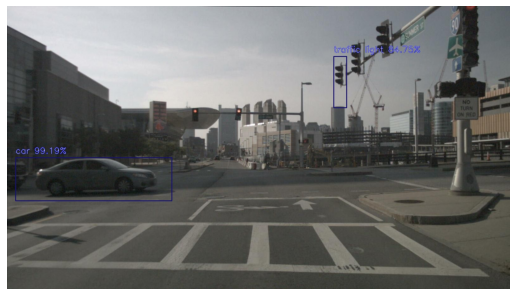

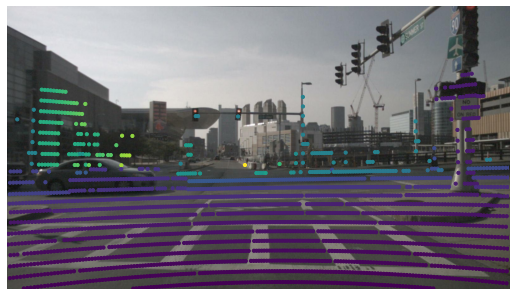

In [4]:
cam_sensor_channel = 'CAM_FRONT'
lidar_sensor_channel = 'LIDAR_TOP'#'RADAR_FRONT'
sf.draw_lidar_on_image(2,5,cam_sensor_channel,lidar_sensor_channel)

Trying to get BOXES

In [7]:
sf.table_dict["scene"][0]

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [8]:
from pprint import pprint
first_scene_token_all_sensors = []
for i in sf.table_dict_token["sample_data"].keys():
    if(sf.table_dict_token["sample_data"][i]["sample_token"] == sf.table_dict["scene"][0]["first_sample_token"]):
        first_scene_token_all_sensors.append(sf.table_dict_token["sample_data"][i])

In [9]:
all_info = {}
scene_tk = sf.table_dict_token["scene"][tuple(sf.table_dict_token["scene"].keys())[0]]['first_sample_token']
sample_tk = sf.table_dict_token["sample"][scene_tk]["token"]
sample_data = sf.table_dict_token["sample_data"]
for tk in sf.table_dict_token["sample_data"].keys():
    if(sample_data[tk]["sample_token"]==sample_tk):
        if "all_sensors" not in all_info.keys():
            all_info['all_sensors'] = [sample_data[tk]]
        else:
            all_info['all_sensors'].append(sample_data[tk])

In [10]:
for sensor_data_10 in all_info['all_sensors']:
    sensor_tk = sf.table_dict_token["calibrated_sensor"][sensor_data_10['calibrated_sensor_token']]['sensor_token']
    sensor_data_10['sensor_modility'] = sf.table_dict_token['sensor'][sensor_tk]['modality']
    sensor_data_10['sensor_channel'] = sf.table_dict_token['sensor'][sensor_tk]['channel']

In [58]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
# dataset\train_data\v1.0-mini dataset\train_data\mini
# nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)
nusc = NuScenes(version='mini', dataroot='train_data', verbose=True)

Loading NuScenes tables for version mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.1 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


In [59]:
nusc.list_scenes()
my_scene = nusc.scene[0]
my_scene

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [60]:
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
my_sample

{'token': 'ca9a282c9e77460f8360f564131a8af5',
 'timestamp': 1532402927647951,
 'prev': '',
 'next': '39586f9d59004284a7114a68825e8eec',
 'scene_token': 'cc8c0bf57f984915a77078b10eb33198',
 'data': {'RADAR_FRONT': '37091c75b9704e0daa829ba56dfa0906',
  'RADAR_FRONT_LEFT': '11946c1461d14016a322916157da3c7d',
  'RADAR_FRONT_RIGHT': '491209956ee3435a9ec173dad3aaf58b',
  'RADAR_BACK_LEFT': '312aa38d0e3e4f01b3124c523e6f9776',
  'RADAR_BACK_RIGHT': '07b30d5eb6104e79be58eadf94382bc1',
  'LIDAR_TOP': '9d9bf11fb0e144c8b446d54a8a00184f',
  'CAM_FRONT': 'e3d495d4ac534d54b321f50006683844',
  'CAM_FRONT_RIGHT': 'aac7867ebf4f446395d29fbd60b63b3b',
  'CAM_BACK_RIGHT': '79dbb4460a6b40f49f9c150cb118247e',
  'CAM_BACK': '03bea5763f0f4722933508d5999c5fd8',
  'CAM_BACK_LEFT': '43893a033f9c46d4a51b5e08a67a1eb7',
  'CAM_FRONT_LEFT': 'fe5422747a7d4268a4b07fc396707b23'},
 'anns': ['ef63a697930c4b20a6b9791f423351da',
  '6b89da9bf1f84fd6a5fbe1c3b236f809',
  '924ee6ac1fed440a9d9e3720aac635a0',
  '91e3608f55174a319

In [63]:
sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
cam_front_data

{'token': 'e3d495d4ac534d54b321f50006683844',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'ego_pose_token': 'e3d495d4ac534d54b321f50006683844',
 'calibrated_sensor_token': '1d31c729b073425e8e0202c5c6e66ee1',
 'timestamp': 1532402927612460,
 'fileformat': 'jpg',
 'is_key_frame': True,
 'height': 900,
 'width': 1600,
 'filename': 'samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg',
 'prev': '',
 'next': '68e8e98cf7b0487baa139df808641db7',
 'sensor_modality': 'camera',
 'channel': 'CAM_FRONT'}

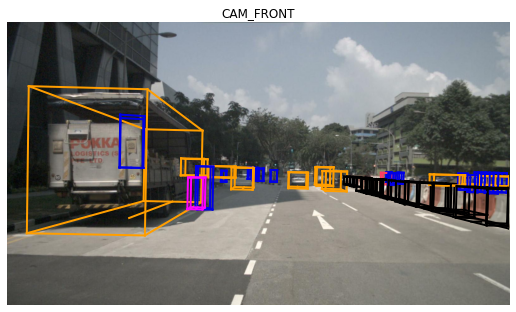

In [64]:
nusc.render_sample_data(cam_front_data['token'])

In [65]:
boxes = nusc.get_boxes(cam_front_data['token'])

[label: nan, score: nan, xyz: [373.26, 1130.42, 0.80], wlh: [0.62, 0.67, 1.64], rot axis: [0.00, 0.00, -1.00], ang(degrees): 21.09, ang(rad): 0.37, vel: nan, nan, nan, name: human.pedestrian.adult, token: ef63a697930c4b20a6b9791f423351da,
 label: nan, score: nan, xyz: [378.89, 1153.35, 0.86], wlh: [0.78, 0.77, 1.71], rot axis: [0.00, 0.00, 1.00], ang(degrees): -112.89, ang(rad): -1.97, vel: nan, nan, nan, name: human.pedestrian.adult, token: 6b89da9bf1f84fd6a5fbe1c3b236f809,
 label: nan, score: nan, xyz: [353.79, 1132.36, 0.60], wlh: [2.01, 4.63, 1.57], rot axis: [0.00, 0.00, -1.00], ang(degrees): 23.11, ang(rad): 0.40, vel: nan, nan, nan, name: vehicle.car, token: 924ee6ac1fed440a9d9e3720aac635a0,
 label: nan, score: nan, xyz: [376.13, 1158.51, 0.94], wlh: [0.75, 0.82, 1.64], rot axis: [0.00, 0.00, 1.00], ang(degrees): 64.77, ang(rad): 1.13, vel: nan, nan, nan, name: human.pedestrian.adult, token: 91e3608f55174a319246f361690906ba,
 label: nan, score: nan, xyz: [410.07, 1196.77, 0.66],